In [1]:
# bert model implementation source 
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert

from transformers import BertTokenizer, TFBertForSequenceClassification

import os
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
import numpy as np
stoplist = stopwords.words('english')
import pandas as pd
import matplotlib.pyplot as plt
data_path = os.getcwd().replace('\\', '/')+'/Data Preprocess/'



num_classes = 5


c:\users\slash\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:


emoji_dict = {"0": ":heart:",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}


# reading the data :
df_train = pd.read_csv(data_path+'train.csv')
df_test = pd.read_csv(data_path+'test.csv')


In [4]:
def plot_hist(hist):
    
    for metric in hist.history.keys():
        if metric.startswith('val'):
            break
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+metric])
        plt.title('model '+metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show() 
        

In [5]:
def preprocess(text, stopword=True, stemming=True):
    # deleting ponctuation, extra spacing and numbers
    text = re.sub("\W+", ' ', text)
    text = re.sub("\d+", ' ', text)
    text = re.sub("\s+", ' ', text)
    
    # tokenizing 
    tokens = text.split(' ')
    # deleting stopwords:
    if stopword:
        tokens = [t for t in tokens if t not in stoplist]
    # stemming :
    if stemming:
        tokens = [PorterStemmer().stem(t) for t in tokens]
    return ' '.join(tokens)

In [6]:
# preprocessing the data :
train_x = df_train["0"].apply(lambda x: 
        preprocess(x, stopword=True, stemming=False)).to_numpy()
train_y = df_train["1"].to_numpy()
test_x = df_test['0'].apply(lambda x: 
        preprocess(x, stopword=True, stemming=False)).to_numpy()
test_y = df_test['1'].to_numpy()




In [9]:

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',
                num_labels=num_classes)

print(bert_tokenizer.tokenize('i will never talk to you again'))



All model checkpoint layers were used when initializing TFBertForSequenceClassification.



Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['i', 'will', 'never', 'talk', 'to', 'you', 'again']


In [10]:
print(bert_tokenizer.tokenize('i will never talk to you again'))


['i', 'will', 'never', 'talk', 'to', 'you', 'again']


In [11]:
train_inputs_ids = []
train_attention_masks = []

for sent in train_x:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,
        max_length =64,pad_to_max_length = True,
        return_attention_mask = True)
    train_inputs_ids.append(bert_inp['input_ids'])
    train_attention_masks.append(bert_inp['attention_mask'])

train_inputs_ids=np.asarray(train_inputs_ids)
train_attention_masks=np.array(train_attention_masks)





Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


c:\users\slash\appdata\local\programs\python\python39\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
test_inputs_ids = []
test_attention_masks = []

for sent in test_x:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,
        max_length =64,pad_to_max_length = True,
        return_attention_mask = True)
    test_inputs_ids.append(bert_inp['input_ids'])
    test_attention_masks.append(bert_inp['attention_mask'])

test_inputs_ids=np.asarray(test_inputs_ids)
test_attention_masks=np.array(test_attention_masks)

In [12]:
import tensorflow as tf

log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
        save_weights_only=True,monitor='val_acc',mode='max',
        save_best_only=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tf_bert_for_sequence_classification"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 bert (TFBertMainLayer)      multiple                  109482240 


 dropout_37 (Dropout)        multiple                  0         


 classifier (Dense)          multiple                  3845      


Total params: 109,486,085


Trainable params: 109,486,085


Non-trainable params: 0


_________________________________________________________________



Bert Model None


In [19]:
history=bert_model.fit([train_inputs_ids,train_attention_masks],
                       train_y,batch_size=16,epochs=10,
                       validation_data=([test_inputs_ids,test_attention_masks],
                        test_y),callbacks=callbacks, verbose=2)


Epoch 1/10


9/9 - 10s - loss: 0.1048 - accuracy: 1.0000 - val_loss: 0.5486 - val_accuracy: 0.7679 - 10s/epoch - 1s/step


Epoch 2/10


9/9 - 10s - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.5536 - val_accuracy: 0.8036 - 10s/epoch - 1s/step


Epoch 3/10


9/9 - 10s - loss: 0.0729 - accuracy: 1.0000 - val_loss: 0.5574 - val_accuracy: 0.8214 - 10s/epoch - 1s/step


Epoch 4/10


9/9 - 10s - loss: 0.0654 - accuracy: 1.0000 - val_loss: 0.5629 - val_accuracy: 0.8393 - 10s/epoch - 1s/step


Epoch 5/10


9/9 - 10s - loss: 0.0562 - accuracy: 1.0000 - val_loss: 0.5608 - val_accuracy: 0.8214 - 10s/epoch - 1s/step


Epoch 6/10


9/9 - 10s - loss: 0.0485 - accuracy: 1.0000 - val_loss: 0.5611 - val_accuracy: 0.8214 - 10s/epoch - 1s/step


Epoch 7/10


9/9 - 10s - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.8036 - 10s/epoch - 1s/step


Epoch 8/10


9/9 - 10s - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.5615 - val_accuracy: 0.8214 - 10s/epoch - 1s/step


Epoch 9/10


9/9 - 10s - loss: 0.0373 - accuracy: 1.0000 - val_loss: 0.5686 - val_accuracy: 0.8393 - 10s/epoch - 1s/step


Epoch 10/10


9/9 - 10s - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.5684 - val_accuracy: 0.8393 - 10s/epoch - 1s/step


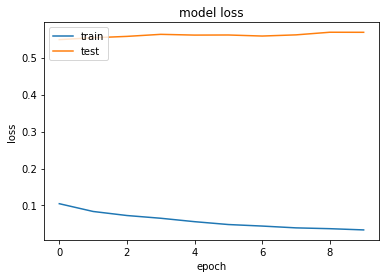

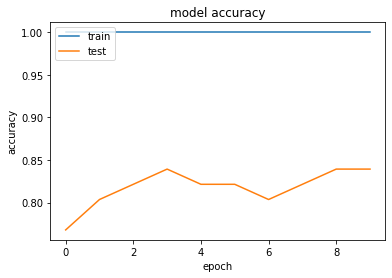

In [21]:
plot_hist(history)